In [148]:
import torch
torch.manual_seed(2)

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [149]:
class System(torch.nn.Module):
    def __init__(self, x0, x_target,tariff, horizon,h, umin,umax):
        self.x0 = x0
        self.horizon = horizon
          # Initialize heating state to 0.5 (OFF)
        mass = 2200 #kg
        cop = 3.53 
        cp = 1.16*10**(-3) #(kWh.J^-1.K^-1)
        gamma = 0.99
        self.x_target = x_target
        self.tariff = tariff


        self.A = gamma
        
        self.h = h 
        
        self.B = self.h*cop/(mass*cp)
        self.Bd = self.h/(mass*cp)
        

        self.umin = umin
        self.umax = umax

        self.ub = (self.umax + self.umin)/2

    def step(self, x,u_bin, d = None, neural = True, hard = False):
        """if d is not None:
            u = d[:, 0:+1, :] + u"""
        cop = torch.min(torch.tensor(6), torch.max(torch.tensor(2),(x+15)/x )) 
        self.cop = cop.clone()  
        #cop = 3.53
        x = self.A*x + cop*self.Bd*u_bin + self.Bd*d
        
        
        self.u = u_bin.clone()
        return x
    
    def rollout(self, controller, tau = 1,d = None, hard = False, neural = True):

        #controller.reset_state(batch_size=d.shape[0])

        x = d[:,0:1,:] if d is not None else self.x0.clone()
        xs = x.clone()
        us = torch.zeros(xs.shape[0],1,1)
        self.us_soft = torch.zeros(xs.shape[0],1,1)
        self.us_hard = torch.zeros(xs.shape[0],1,1)
        self.cop_h = torch.zeros(xs.shape[0],1,1)


        for t in range(1,self.horizon-1):

            u_bin = controller(x,d[:,t:t+1,:],self.x_target[:,t:t+1,:], self.tariff[:,t:t+1,:],tau = tau,  hard = hard)
            x = self.step(x, u_bin,d[:,t:t+1,:], neural=neural, hard=hard)

            xs = torch.cat((xs, x), 1)
            us = torch.cat((us, u_bin), 1)
            self.cop_h = torch.cat((self.cop_h, self.cop), 1)

            if hard:
                self.us_soft = torch.cat((self.us_soft, controller.u_soft), 1)
                self.us_hard = torch.cat((self.us_hard, controller.u_hard), 1)

        return xs, us
    
class Dataset():    
    def __init__(self, x0, horizon,xmin,xmax):
        self.x0 = x0
        self.horizon = horizon
        self.batch_size = self.x0.shape[0]
        self.xmin = xmin
        self.xmax = xmax
    """def generate_data(self):
        d = torch.zeros((self.batch_size, self.horizon+1, 1))
        d[:, 0, :] = ((self.xmax-self.xmin)*torch.rand((self.batch_size, 1))+self.xmin)
        #d[:, 0, :] = 80

        d[:,1:,:] = (-torch.randn((self.batch_size, d.shape[1]-1, 1))*2-2.5)*4
        return d"""
    def generate_data(self):
        # time grid over 24h, normalized to [0, 24)
        t = torch.linspace(0, 24, self.horizon+1)  # shape (horizon+1,)
        t = t.unsqueeze(0).repeat(self.batch_size, 1)  # (B, T)

        # baseline around 5 with small randomization per sample
        base = 5.0 + 1.0 * torch.randn(self.batch_size, 1)  # (B,1)

        # morning bump ~7–9h
        morning_center = 8.0
        morning_width = 2.0
        morning_amp = 8.0
        morning = morning_amp * torch.exp(-0.5 * ((t - morning_center) / morning_width) ** 2)

        # evening peak ~18–22h
        evening_center = 19.5
        evening_width = 2.5
        evening_amp = 22.0
        evening = evening_amp * torch.exp(-0.5 * ((t - evening_center) / evening_width) ** 2)

        # raw profile (B, T)
        d_raw = base + morning + evening

        # add some noise
        noise = 1.5 * torch.randn(self.batch_size, self.horizon+1)
        d_raw = d_raw + noise

        # clip to [xmin, xmax] and enforce non-negativity
        d_raw = torch.clamp(d_raw, min=0.0)

        # final shape (B, T, 1)
        d = -d_raw.unsqueeze(-1)

        d[:, 0, :] = ((self.xmax-self.xmin)*torch.rand((self.batch_size, 1))+self.xmin)

        return d

class Loss():
    def __init__(
        self, R, u_min, u_max, x_min,x_max,x_ref,peak = False, renewable_fossil_peak = False,
        alpha_xl=None, alpha_xh=None,
        loss_bound=None, sat_bound=None, tariff = None,
    ):
        
        self.peak = peak

        self.umin = u_min
        self.umax = u_max
        self.xmin = x_min
        self.xmax = x_max

        self.loss_bound = loss_bound
        self.sat_bound = sat_bound

        self.alpha_xl = alpha_xl
        self.alpha_xh = alpha_xh

        #Weight of the base lost
        self.R = R
        

        self.x_ref = x_ref


        #Create tariff over time vector
        self.tariff = tariff


    def forward(self, xs, us):      ## removed dxref
        """
        Compute loss.

        Args:
            - xs: tensor of shape (S, T, state_dim)
            - us: tensor of shape (S, T, in_dim)

        Return:
            - loss of shape (1, 1).
        """

        # batch
        x_batch = xs.reshape(*xs.shape,1)
        u_batch = us.reshape(*us.shape, 1)
        
        error = (xs - self.x_ref).reshape(*xs.shape,1)
        # dxref = dxref.reshape(*dxref.shape, 1)

        # loss states = 1/T sum_{t=1}^T (x_t-xbar)^T Q (x_t-xbar)
        
        # loss control actions = 1/T sum_{t=1}^T u_t^T R u_t

        if self.peak:
            cost = us*self.tariff 
            

            loss_u = torch.sum(cost,1)/ u_batch.shape[1] 
            loss_u = loss_u.reshape(*loss_u.shape,1)

        else: 
            uTRu = self.R * torch.matmul(
                error.transpose(-1, -2),
                error
            )   # shape = (S, T, 1, 1)
            loss_u = torch.sum(uTRu, 1) / x_batch.shape[1] 

        # upper bound on temperature loss
        if self.alpha_xh is None:
            loss_xh = 0
        else:
            loss_xh = self.alpha_xh * self.f_upper_bound_x(x_batch)       # shape = (S, 1, 1)

        # lower bound on temperature loss
        if self.alpha_xl is None:
            loss_xl = 0
        else:
            loss_xl = self.alpha_xl * self.f_lower_bound_x(x_batch) # shape = (S, 1, 1)

        self.l_xl = torch.sum(loss_xl, 0)/xs.shape[0]
        
        self.l_xh = torch.sum(loss_xh, 0)/xs.shape[0]

        # loss on switching pump ON/OFF, continuous or discrete or off
        switch_loss_mode = "off"
        if switch_loss_mode == "off":
            switch_loss = 0
        elif switch_loss_mode == "continuous" | "discrete":
            u_bool = u_batch >= 0.01
            switch_number = (u_bool[:, 1:, :, :] ^ u_bool[:, :-1, :, :]).float()
            if switch_loss_mode == "discrete":
                #discrete
                switch_penalty = switch_number
            if switch_loss_mode == "continuous":
                u_smooth = torch.sigmoid(u_batch)  # Output between 0 and 1
                # Compute the difference between consecutive time steps along the time dimension (dim=1)
                # This will give us the "change" between consecutive time steps
                # switch_penalty = torch.abs(u_smooth[:, 1:, :, :] - u_smooth[:, :-1, :, :])  # L1 difference
                # Optionally, use the L2 difference (squared difference) instead
                switch_penalty = (u_smooth[:, 1:, :, :] - u_smooth[:, :-1, :, :]).pow(2)  # L2 difference
            switch_switch_loss = switch_penalty.sum()
            alpha_switch = 0.07
            switch_loss = alpha_switch * switch_loss
            self.l_switch = torch.sum(switch_number.sum(), 0)

        # sum up all losses
        loss_val = loss_u + loss_xh + loss_xl           # + switch_loss          # shape = (S, 1, 1)

        # bound
        if self.sat_bound is not None:
            loss_val = torch.tanh(loss_val/self.sat_bound)  # shape = (*batch_dim, 1, 1)
        if self.loss_bound is not None:
            loss_val = self.loss_bound * loss_val           # shape = ((*batch_dim, 1, 1
        
        loss_val = torch.sum(loss_val, 0)/xs.shape[0]       # shape = (1, 1)
        
        return loss_val

    
    def f_upper_bound_x(self, x_batch): 
        """
        Args:
            - x_batched: tensor of shape (S, T, state_dim, 1)
        """

        
        delta = x_batch - self.xmax

        loss_bound = torch.relu(delta) ##
        # loss_bound = torch.nn.functional.softplus(delta, beta = 2.0) ##
        loss_xh = loss_bound.sum(1)/loss_bound.shape[1]
        return loss_xh.reshape(-1,1,1)



    def f_lower_bound_x(self, x_batch,s = True):

        delta = self.xmin - x_batch  

        loss_bound = torch.relu(delta) ##
        # loss_bound = torch.nn.functional.softplus(delta, beta = 2.0)
        if s == True: 
            loss_xl = loss_bound.sum(1)/loss_bound.shape[1]
            return loss_xl.reshape(-1,1,1)
        else: 
            return loss_bound


## Gumbel

In [150]:
class Controller_Gumbel(nn.Module):
    def __init__(self,xbase = 1.0,dbase = 1,umin = 2, umax = 6):
        super().__init__()

        n_in = 4
        self.net = nn.Sequential(
            nn.Linear(n_in, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # output logit
        )
        self.xbase = xbase
        self.dbase = dbase

        self.umin = umin
        self.umax = umax

        self.net_c = nn.Sequential(
            nn.Linear(n_in, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # output logit
        )

    def forward(self, x,d,x_ref,tariff, tau=1.0, hard=False):
        x = x/self.xbase
        x_ref = x_ref/self.xbase
        d = d/self.dbase
        input = torch.cat((x,d,x_ref,tariff), dim=2)
        
        logits = self.net(input)

        u_cont = (self.umax-self.umin)*torch.sigmoid(self.net_c(input))+self.umin

        u = torch.rand_like(logits)

        #g = -torch.log(-torch.log(u))
        
        n = torch.log(u)-torch.log(1-u)
        u_soft = torch.sigmoid((logits+n)/tau)  # shape: [batch, 1]

        self.u_soft = u_soft.clone()    
        if hard == True:
            u_hard = (u_soft > 0.5).float()
            self.u_hard = u_hard.clone()
            u_out = u_hard*u_cont
            return u_out
        else:
            u_out = u_soft*u_cont
            return u_out

In [151]:
nb = 400
x0 = torch.zeros((nb,1,1))
#x0[0,0,0] = 10


horizon = 96
h = 0.25

T_min = 28
T_max = 38

T_ext = 20
T_ref = 36

# changing into correct states to control
x_min = T_min - T_ext 
x_max = T_max - T_ext
x_target_1 = T_ref - T_ext
x_target_2 = T_ref-6 - T_ext
t = torch.arange(horizon-1).view(1, horizon-1, 1)

# piecewise target
umin = 4
umax = 24

alpha_low = 100
alpha_high = 30

high = [1]*48
low = [6]*47
tariff = torch.tensor(high+low).view(1,len(high+low),1).expand(nb,len(high+low),1)

data = Dataset(x0, horizon,x_min,x_max)
d = data.generate_data()
test_d = data.generate_data()

x_target = torch.ones((d.shape[0],d.shape[1]-2,d.shape[2]))*x_target_1
x_target[:,48:150,:] = x_target_2
"""x_target[:,150:250,:] = x_target_1-3
x_target[:,250:350,:] = x_target_2
x_target[:,350:,:] = x_target_1"""
dbase = torch.max(torch.abs(d[:,1:,:])).item()


Epoch 0, Loss: 182.0040
Epoch 400, Loss: 21.1612
Epoch 800, Loss: 19.7444
Epoch 1200, Loss: 19.7372
Epoch 1600, Loss: 19.5770
Epoch 2000, Loss: 19.0955
Epoch 2400, Loss: 19.1810
Epoch 2800, Loss: 19.0159
Epoch 3200, Loss: 19.3068
Epoch 3600, Loss: 19.5472
Test Loss: 3.9512


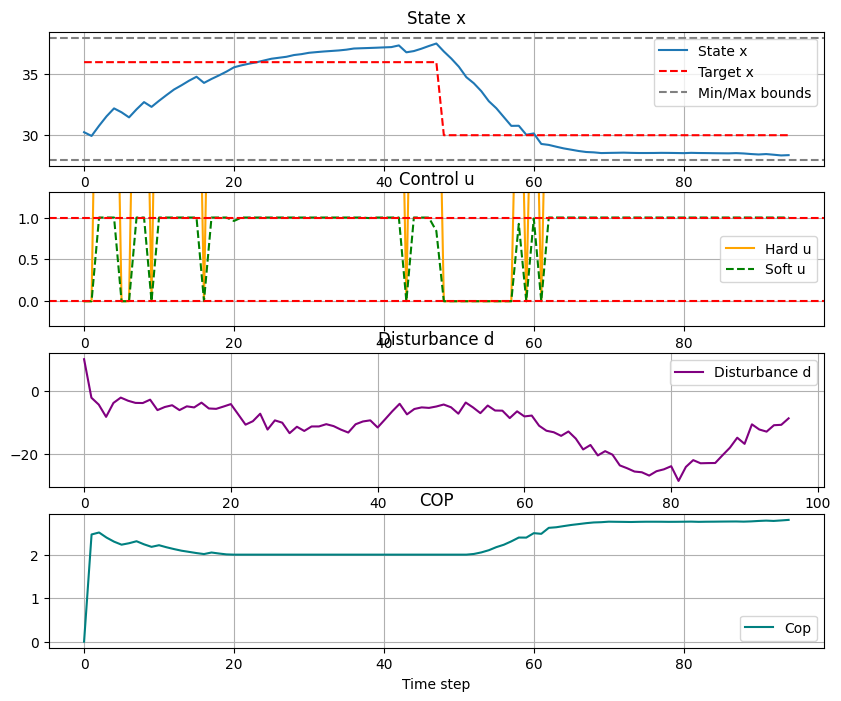

In [152]:




sys = System(x0,x_target,tariff,horizon,h,umin=umin, umax=umax)


controller = Controller_Gumbel(xbase = x_max, dbase = 3, umin=umin, umax=umax)

loss_fn = Loss(R=0.0, u_min=0.0, u_max=0.0, x_min=x_min, x_max=x_max,x_ref=x_target,
    alpha_xl=alpha_low, alpha_xh=alpha_high,
    peak=True, tariff=tariff[0:1,:,:]
)

tau_0 = 1.0
alpha = 0.995
tau_min = 0.1
"""tariff = [0]*11 + [10]*12
tariff = torch.tensor(tariff).float().view(1,-1,1)"""

best_loss = float('inf')
best_params = None

num_epochs = 4000
log_epochs = num_epochs // 10
optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    optimizer.zero_grad()

    tau = max(tau_0 * (alpha ** epoch), tau_min)
    #tau = 0.1
    xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

    #loss = torch.mean((xs - x_target)**2) 
    loss = loss_fn.forward(xs, us) 
    loss.backward()
    optimizer.step()

    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = controller.state_dict()

# Load the best parameters
controller.load_state_dict(best_params)
with torch.no_grad():
    x_log, u_log = sys.rollout(controller,tau = tau,d = d, hard=True)
    
    #loss = loss_fn.forward(x_log, u_log)

loss = torch.mean((x_log- x_target)**2) 
print(f"Test Loss: {loss.item():.4f}")
x_log_01 = x_log.clone()
u_log_01 = sys.us_soft
fig, ax = plt.subplots(4,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy()+T_ext, label='State x')
"""ax[0].plot(x_log[1,:,:].detach().numpy(), label='State x')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='State x')"""
ax[0].plot(x_target[0,:,:]+T_ext, color='r', linestyle='--', label='Target x')
ax[0].axhline(y=x_min+T_ext, color='grey', linestyle='--', label='Min/Max bounds')
ax[0].axhline(y=x_max+T_ext, color='grey', linestyle='--')
ax[0].set_title('State x')
#ax[0].set_ylim(0, 15)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()

ax[2].plot(d[0,:,0].detach().numpy(), label='Disturbance d', color='purple')
ax[2].set_title('Disturbance d')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()

ax[3].plot(sys.cop_h[0,:,0].detach().numpy(), label='Cop', color='teal')
ax[3].set_title('COP')
ax[3].set_xlabel('Time step')
ax[3].legend()
ax[3].grid()



"ax[2].plot(d[0,:,0].detach().numpy(), label='Disturbance d', color='purple')\nax[2].set_title('Disturbance d')\nax[2].set_xlabel('Time step')\nax[2].legend()\nax[2].grid()"

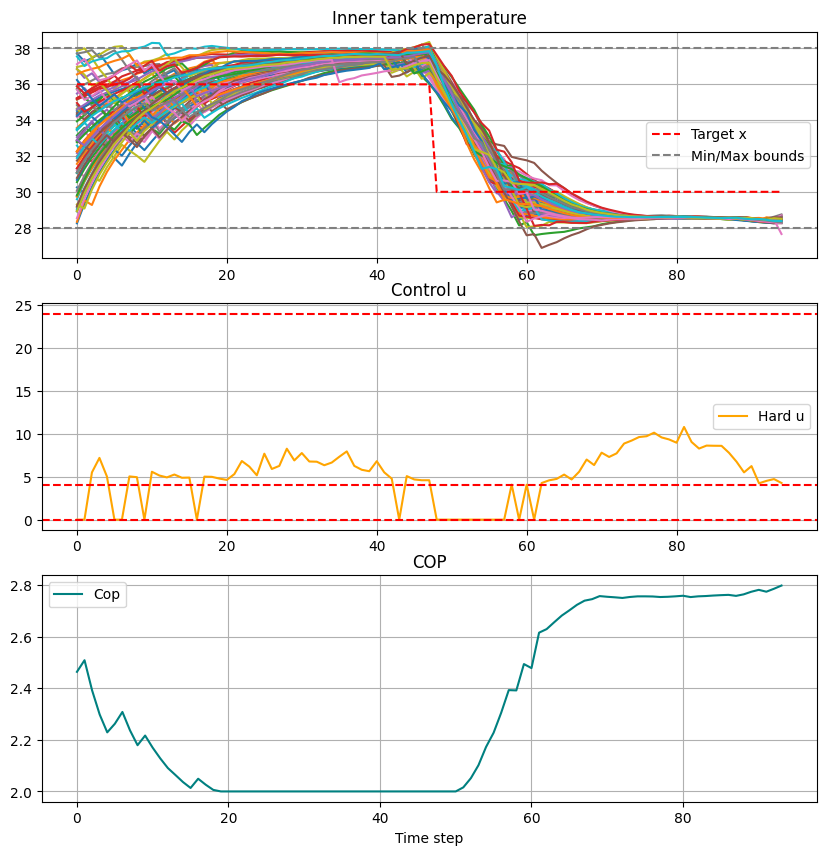

In [153]:
fig, ax = plt.subplots(3,1, figsize=(10,10))
for i in range(80):
    ax[0].plot(x_log[i,:,:].detach().numpy()+T_ext)
ax[0].plot(x_target[0,:,:]+T_ext, color='r', linestyle='--', label='Target x')
ax[0].axhline(y=x_min+T_ext, color='grey', linestyle='--', label='Min/Max bounds')
ax[0].axhline(y=x_max+T_ext, color='grey', linestyle='--')
ax[0].set_title('Inner tank temperature')
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
#ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
#ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=umin, color='r', linestyle='--')
ax[1].axhline(y=umax, color='r', linestyle='--')

ax[1].legend()
ax[1].grid()

ax[2].plot(sys.cop_h[0,1:,0].detach().numpy(), label='Cop', color='teal')
ax[2].set_title('COP')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()

"""ax[2].plot(d[0,:,0].detach().numpy(), label='Disturbance d', color='purple')
ax[2].set_title('Disturbance d')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()"""

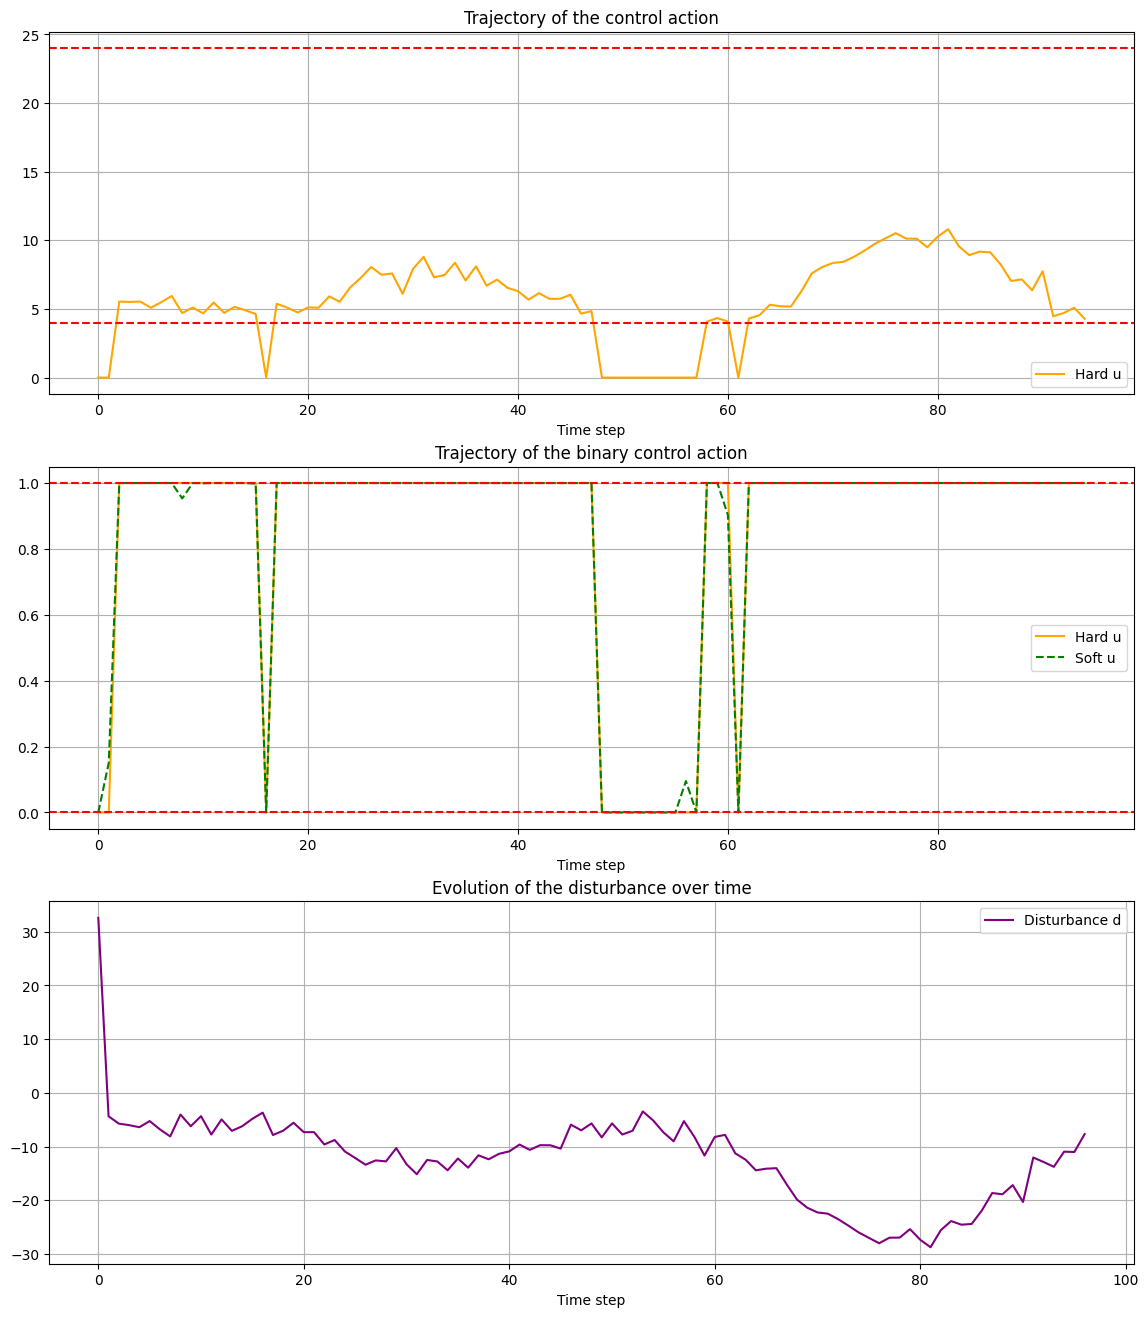

In [154]:
index = 9

fig, ax = plt.subplots(3,1, figsize=(14,16))

ax[0].plot(u_log[index,:,:].detach().numpy(), label='Hard u', color='orange')
ax[0].axhline(y=umin, color='r', linestyle='--')
ax[0].axhline(y=umax, color='r', linestyle='--')
ax[0].set_title('Trajectory of the control action')
ax[0].set_xlabel('Time step')
ax[0].legend()
ax[0].grid()


ax[1].plot(sys.us_hard[index,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[index,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Trajectory of the binary control action')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')

ax[1].legend()
ax[1].grid()
d_ = d.clone()
d_[:,0,:] = d_[:,0,:]+T_ext
ax[2].plot(d_[index,:,0].detach().numpy(), label='Disturbance d', color='purple')
ax[2].set_title('Evolution of the disturbance over time')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()

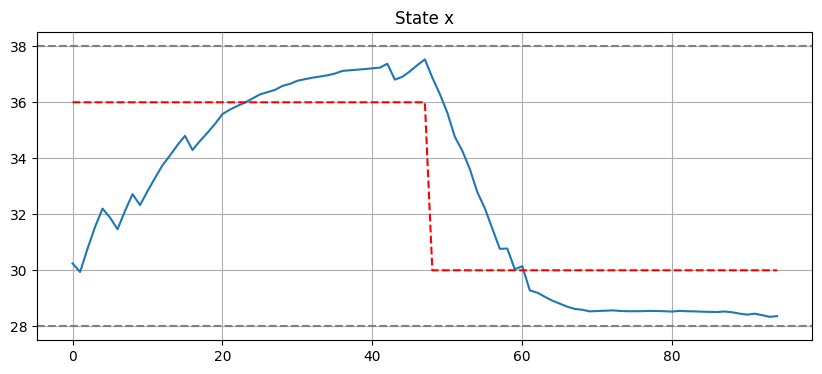

In [155]:
plt.figure(figsize = (10,4))
plt.plot(x_log[0,:,:].detach().numpy()+T_ext, label='State x')
"""ax[0].plot(x_log[1,:,:].detach().numpy(), label='State x')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='State x')"""
plt.plot(x_target[0,:,:]+T_ext, color='r', linestyle='--', label='Target x')
plt.axhline(y=x_min+T_ext, color='grey', linestyle='--', label='Min/Max bounds')
plt.axhline(y=x_max+T_ext, color='grey', linestyle='--')
plt.title('State x')
#ax[0].set_ylim(0, 15)
plt.grid()